# Grover's algorithm for multiple solutions 

This small project is based on Qiskit textbook's [Grover's search algorithm](https://learn.qiskit.org/course/introduction/grovers-search-algorithm).

## Import basic modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, Aer, transpile
from qiskit.quantum_info.operators import Operator
from qiskit.tools.visualization import plot_histogram
from typing import List
%matplotlib inline

## Preparation

Define CCZ as a tool for oracle creation and diffuser definition described below.

In [2]:
# If setting n_qubits > 3, we should define CC...CZ instead (see below).
def ccz(qc: QuantumCircuit, q1: int, q2: int, t: int) -> None:
    ccz_qc = QuantumCircuit(3)
    ccz_qc.h(2)
    ccz_qc.ccx(0, 1, 2)
    ccz_qc.h(2)
    # q1->0, q2->1, t->3
    qc.compose(ccz_qc, [q1, q2, t], inplace=True)

# CC...CZ
def ccnz(qc: QuantumCircuit, controls:List[int], target: int) -> None:
    n = len(controls) + 1
    size = 2**n
    unitary_matrix = []
    for i in range(size):
        row = [0]*size
        row[i] = 1
        if i == size - 1:
            row[i] *= -1
        unitary_matrix.append(row)
    
    ccnz_op = Operator(unitary_matrix)
    ccnz_qc = QuantumCircuit(n)
    ccnz_qc.append(ccnz_op, list(range(n)))
    qc.compose(ccnz_qc, [*controls, target], inplace=True)

## Define the oracle

This time, we assume that the solutions to the problem are $|101\rangle$ and $|111\rangle$.

In [3]:
n_qubits = 3
solutions = ['101', '111']

def revserse_phase(qc: QuantumCircuit, state: str):
    qubits = []
    for i, digit in enumerate(state[::-1]):
        if digit == '0':
            qubits.append(i)
    if qubits:
        qc.x(qubits)
    ccnz(qc, list(range(n_qubits - 1)), n_qubits - 1)
    if qubits:
        qc.x(qubits)

def define_oracle():
    # Create the oracle with two solutions: |101> and |111>
    qreg = QuantumRegister(n_qubits, 'qr')
    oracle = QuantumCircuit(qreg)

    for sol in solutions:
        revserse_phase(oracle, sol)

    return oracle

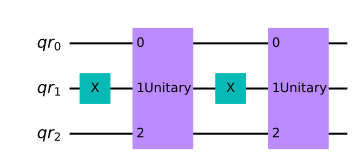

In [4]:
oracle = define_oracle()
oracle.draw()

### Check the state vector to be sure

In [5]:
from qiskit.quantum_info import Statevector

sv = Statevector.from_label('0'*n_qubits)
init_qreg = QuantumRegister(n_qubits, 'qr')
init = QuantumCircuit(init_qreg)
init.h(init_qreg[:])
oracle2 = sv.evolve(init.compose(oracle))
oracle2.draw('latex')

<IPython.core.display.Latex object>

It was confirmed that the state vector was obtained as expected.

## First, try solving problems with Qiskit's built-in tools, following the textbook

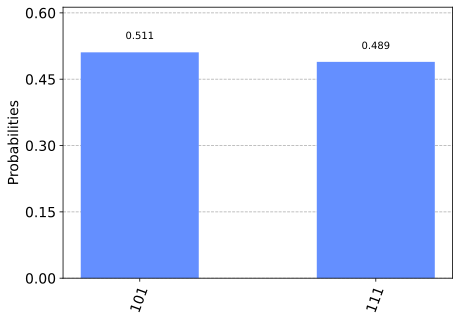

In [6]:
from qiskit.circuit.library import GroverOperator
grover_operator = GroverOperator(oracle)

init = QuantumCircuit(3)
init.h([0, 1, 2])
circuit = init.compose(grover_operator)
circuit.measure_all()
circuit.draw()

sim = Aer.get_backend('aer_simulator')
t_circuit = transpile(circuit, sim)
counts = sim.run(t_circuit).result().get_counts()
plot_histogram(counts)

Now that we have completed the definition of the orcle and verified that it is appropriate, let's build our own circuit to solve the problem, following the example of textbook.

## Next, try solving problems with our own circuit

### Define the diffuser

Recall that the oracle is the circuit which reflects a state around the state $|✗\rangle$. While the diffuser is the circuit which reflects a state around the state $|s\rangle$, so it transforms $|s\rangle \xrightarrow{HH\cdots H} |11\cdots 1\rangle \xrightarrow{CC\cdots CZ} -|11\cdots 1\rangle \xrightarrow{HH\cdots H} -|s\rangle$ according to the textbook.

In [7]:
def define_diffuser():
    qreg = QuantumRegister(n_qubits, 'qr')
    diffuser = QuantumCircuit(qreg)
    diffuser.h(qreg[:])
    diffuser.x(qreg[:])
    ccnz(diffuser, list(range(n_qubits - 1)), n_qubits - 1)
    diffuser.x(qreg[:])
    diffuser.h(qreg[:])
    
    return diffuser

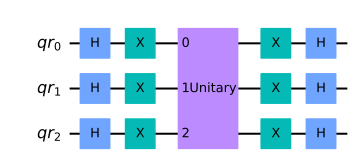

In [8]:
diffuser = define_diffuser()
diffuser.draw()

## How many times should we query the oracle?

Roughly, we can estimate $\frac{\pi}{2} \div \sqrt{\frac{n_{sol}}{N}}$ using the number of qubits $N$ and the number of solutions $n_{sol}$.

In [9]:
angle = np.arcsin(np.sqrt(len(solutions) / n_qubits))
counts = int((np.pi/2) / angle)
print(f'{angle=}, {np.pi/2=}, {counts=}')

angle=0.9553166181245093, np.pi/2=1.5707963267948966, counts=1


## Let's solve the problem applying Grover's algorithm!

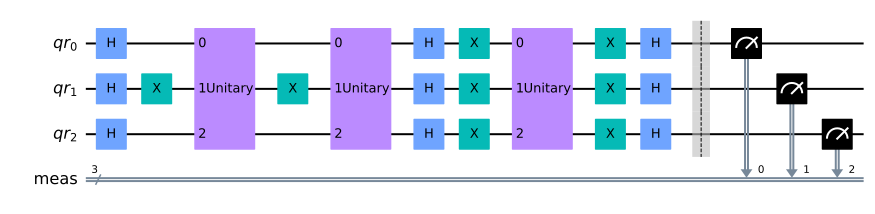

In [10]:
qreg = QuantumRegister(n_qubits, 'qr')
grover = QuantumCircuit(qreg)
# initialize |s>
grover.h(qreg[:])
for _ in range(counts):
    grover = grover.compose(oracle)
    grover = grover.compose(diffuser)
grover.measure_all()
grover.draw()

In [11]:
sim = Aer.get_backend('aer_simulator')
transpiled_grover = transpile(grover, backend=sim)

print(f'circuit depth={transpiled_grover.depth()}')

circuit depth=8


{'101': 517, '111': 507}


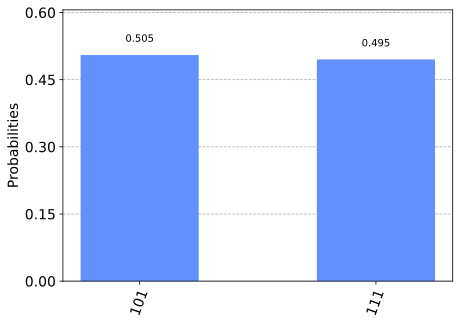

In [12]:
result = sim.run(transpiled_grover).result()
print(result.get_counts())
plot_histogram(result.get_counts())

Ok. We got the solution we were looking for!

## Finally, let's try it out on an actual device

Grover's algorithm is for FTQC, but some actual machines can give a solution if n_qubits <= 3. For example, `ibm_oslo` seems to work.

In [13]:
from qiskit import IBMQ
from qiskit.tools import job_monitor

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibm_oslo')

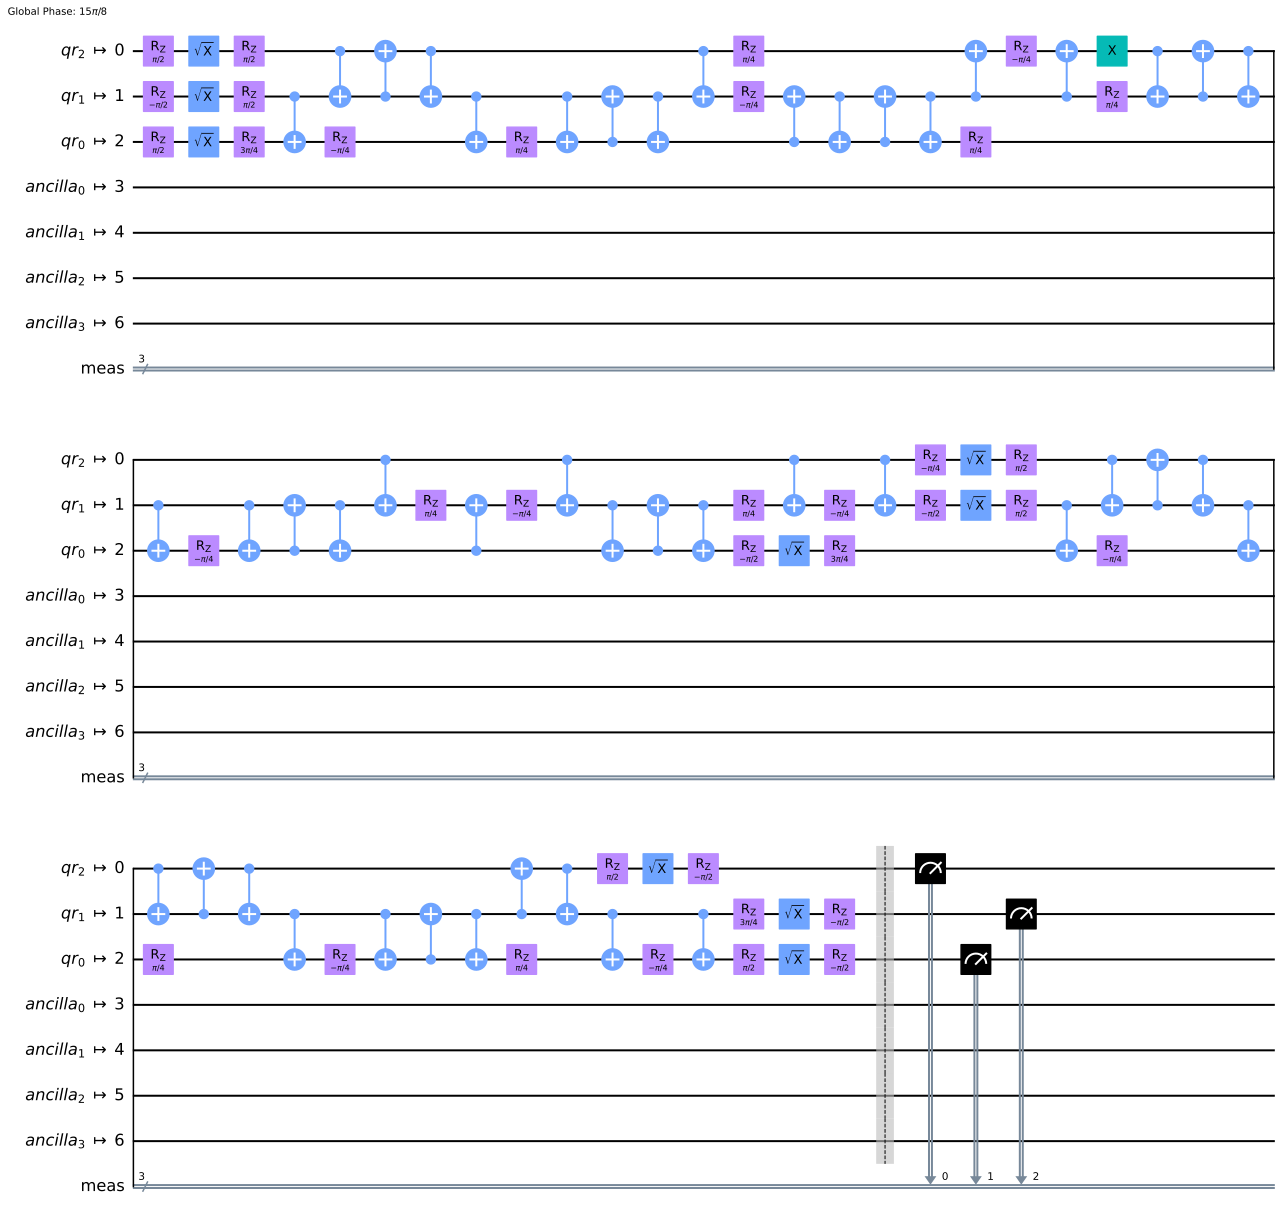

In [14]:
transpiled_grover = transpile(grover, backend)
transpiled_grover.draw()

In [15]:
print(f'transpiled circuit depth={transpiled_grover.depth()}')

transpiled circuit depth=67


In [16]:
job = backend.run(transpiled_grover)

In [17]:
job_monitor(job)

Job Status: job has successfully run


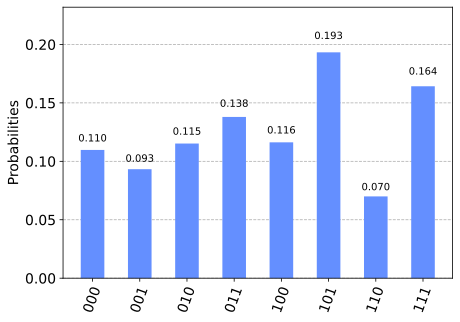

In [18]:
result = job.result()
plot_histogram(result.get_counts())

In [19]:
import qiskit.tools.jupyter
%qiskit_version_table